<a href="https://colab.research.google.com/github/adhilabu/ai-ml-learning-training/blob/main/manus_analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install psycopg2 pandas finta

In [ ]:
!rm -rf preprocessed_data.csv
!rm -rf stock_data
!rm -rf stock_statistics.csv
!rm -rf strategy_results
!rm -rf visualizations

In [ ]:
import psycopg2
import pandas as pd
import json
import os
import time

# Database connection and data fetch
def fetch_data():
    print("Connecting to database...")
    db_params = {
        'host': '0.tcp.in.ngrok.io',
        'port': 17189,
        'database': 'aksyo_wiz',
        'user': 'postgres',
        'password': 'adhilabacker'
    }

    try:
        conn = psycopg2.connect(**db_params)
        print("Connection successful. Fetching data...")
        query = "select timestamp, stock, high, low, close, open, volume, mfi, vwap, rsi, adx, upperband, lowerband, middleband from historical_data_indi;"
        df = pd.read_sql_query(query, conn)
        conn.close()
        print(f"Data fetched successfully. Total rows: {len(df)}")
        return df
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

# Save data to CSV
def save_data(df, filename='historical_data.csv'):
    if df is not None:
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
        return True
    return False

if __name__ == "__main__":
    start_time = time.time()
    data = fetch_data()
    if data is not None:
        # Print data info
        print("\nData Information:")
        print(data.info())

        # Print first few rows
        print("\nFirst 5 rows:")
        print(data.head())

        # Check for unique stocks
        unique_stocks = data['stock'].unique()
        print(f"\nNumber of unique stocks: {len(unique_stocks)}")
        print(f"Sample stocks: {unique_stocks[:10] if len(unique_stocks) > 10 else unique_stocks}")

        # Save data
        save_data(data)

    elapsed_time = time.time() - start_time
    print(f"\nTotal execution time: {elapsed_time:.2f} seconds")


Connecting to database...
Error connecting to database: connection to server at "0.tcp.in.ngrok.io" (13.202.226.61), port 17189 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


Total execution time: 0.22 seconds


Loading historical data...
Calculating additional technical indicators...
Creating separate dataframes for 34 stocks...
Processing stock: NSE_EQ|INE002A01018
Processing stock: NSE_EQ|INE009A01021
Processing stock: NSE_EQ|INE019A01038
Processing stock: NSE_EQ|INE029A01011
Processing stock: NSE_EQ|INE030A01027
Processing stock: NSE_EQ|INE038A01020
Processing stock: NSE_EQ|INE040A01034
Processing stock: NSE_EQ|INE044A01036
Processing stock: NSE_EQ|INE059A01026
Processing stock: NSE_EQ|INE062A01020
Processing stock: NSE_EQ|INE066A01021
Processing stock: NSE_EQ|INE075A01022
Processing stock: NSE_EQ|INE081A01020
Processing stock: NSE_EQ|INE089A01031
Processing stock: NSE_EQ|INE090A01021
Processing stock: NSE_EQ|INE095A01012
Processing stock: NSE_EQ|INE101A01026
Processing stock: NSE_EQ|INE154A01025
Processing stock: NSE_EQ|INE155A01022
Processing stock: NSE_EQ|INE158A01026
Processing stock: NSE_EQ|INE192A01025
Processing stock: NSE_EQ|INE213A01029
Processing stock: NSE_EQ|INE216A01030
Proces

<ipython-input-26-8e17307cdacc>:159: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-26-8e17307cdacc>:160: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('visualizations/technical_indicators.png')


Preprocessing completed successfully!


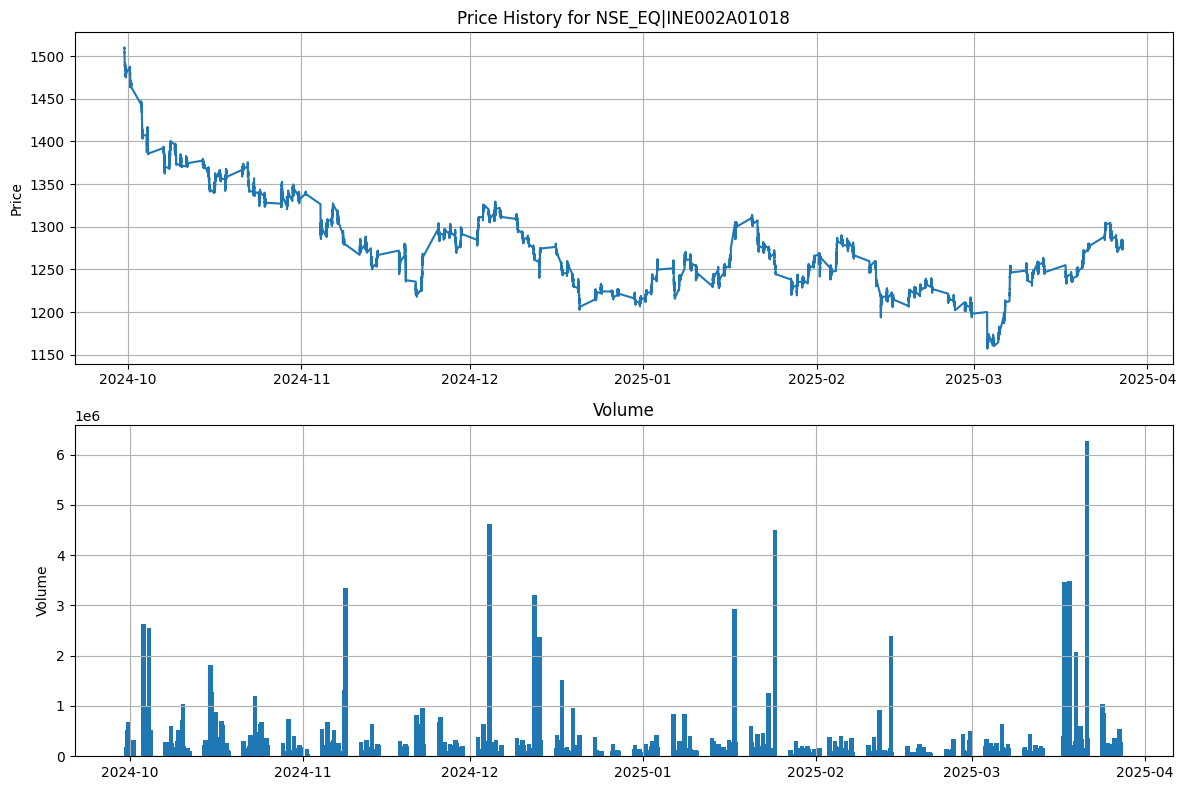

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


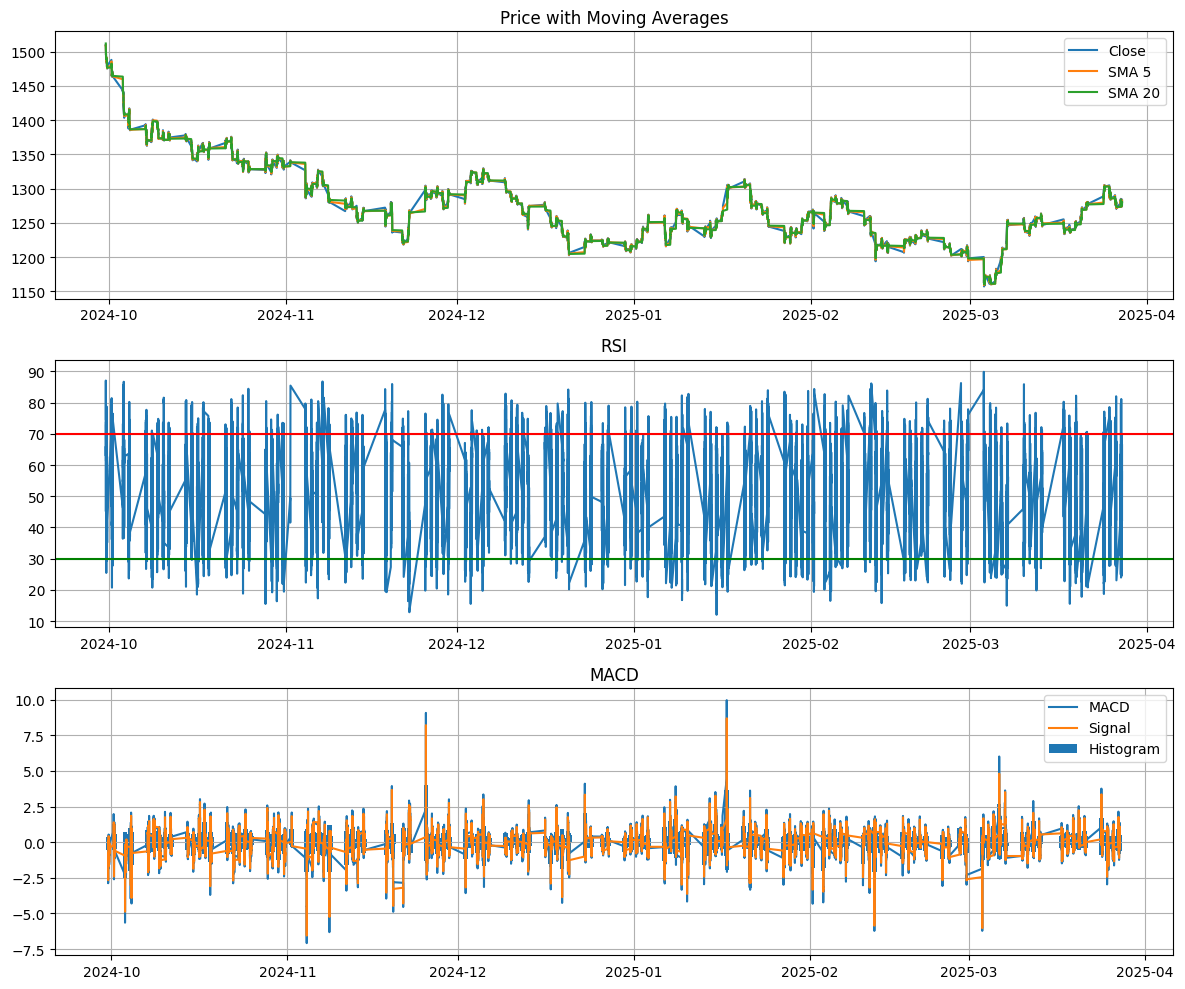

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data():
    print("Loading historical data...")
    df = pd.read_csv('historical_data.csv')

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Sort data by stock and timestamp
    df = df.sort_values(['stock', 'timestamp'])

    # Extract date and time components
    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.time

    # Clean stock symbols - remove exchange prefix
    df['symbol'] = df['stock'].str.split('|').str[1]

    # Calculate additional features
    print("Calculating additional technical indicators...")

    # Calculate price changes
    df['price_change'] = df.groupby('stock')['close'].diff()
    df['price_change_pct'] = df.groupby('stock')['close'].pct_change() * 100

    # Calculate moving averages if not already present
    df['sma_5'] = df.groupby('stock')['close'].transform(lambda x: x.rolling(window=5).mean())
    df['sma_20'] = df.groupby('stock')['close'].transform(lambda x: x.rolling(window=20).mean())
    df['ema_9'] = df.groupby('stock')['close'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

    # Calculate MACD
    df['ema_12'] = df.groupby('stock')['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['ema_26'] = df.groupby('stock')['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df.groupby('stock')['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # Calculate ATR (Average True Range) for volatility
    df['tr1'] = df.groupby('stock')['high'].transform(lambda x: x.shift(0)) - df.groupby('stock')['low'].transform(lambda x: x.shift(0))
    df['tr2'] = abs(df.groupby('stock')['high'].transform(lambda x: x.shift(0)) - df.groupby('stock')['close'].transform(lambda x: x.shift(1)))
    df['tr3'] = abs(df.groupby('stock')['low'].transform(lambda x: x.shift(0)) - df.groupby('stock')['close'].transform(lambda x: x.shift(1)))
    df['true_range'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
    df['atr_14'] = df.groupby('stock')['true_range'].transform(lambda x: x.rolling(window=14).mean())

    # Calculate Stochastic Oscillator
    df['lowest_14'] = df.groupby('stock')['low'].transform(lambda x: x.rolling(window=14).min())
    df['highest_14'] = df.groupby('stock')['high'].transform(lambda x: x.rolling(window=14).max())
    df['%K'] = ((df['close'] - df['lowest_14']) / (df['highest_14'] - df['lowest_14'])) * 100
    df['%D'] = df.groupby('stock')['%K'].transform(lambda x: x.rolling(window=3).mean())

    # Calculate OBV (On-Balance Volume)
    df['price_direction'] = np.where(df.groupby('stock')['close'].diff() > 0, 1, -1)
    df['price_direction'] = np.where(df.groupby('stock')['close'].diff() == 0, 0, df['price_direction'])
    df['obv_change'] = df['volume'] * df['price_direction']
    df['obv'] = df.groupby('stock')['obv_change'].cumsum()

    # Drop temporary columns
    df = df.drop(['tr1', 'tr2', 'tr3', 'price_direction', 'obv_change'], axis=1)

    # Handle NaN values
    df = df.dropna()

    # Create separate dataframes for each stock
    stock_dfs = {}
    stocks_to_print = list(df['stock'].unique())
    print(f"Creating separate dataframes for {len(stocks_to_print)} stocks...")
    for stock in stocks_to_print:
        print(f"Processing stock: {stock}")

    for stock in df['stock'].unique():
        stock_dfs[stock] = df[df['stock'] == stock].copy()

    # Save preprocessed data
    print("Saving preprocessed data...")
    df.to_csv('preprocessed_data.csv', index=False)

    # Create a directory for individual stock data
    os.makedirs('stock_data', exist_ok=True)

    # Save individual stock data
    for stock, stock_df in stock_dfs.items():
        stock_name = stock.split('|')[1]
        print(f"Saving stock data for {stock_name}...")
        stock_df.to_csv(f'stock_data/{stock_name}.csv', index=False)

    # Generate basic statistics
    print("Generating basic statistics...")
    stats_df = pd.DataFrame()
    for stock, stock_df in stock_dfs.items():
        stock_name = stock.split('|')[1]
        stats = {
            'stock': stock_name,
            'days': len(stock_df['date'].unique()),
            'avg_price': stock_df['close'].mean(),
            'min_price': stock_df['close'].min(),
            'max_price': stock_df['close'].max(),
            'avg_volume': stock_df['volume'].mean(),
            'avg_volatility': stock_df['atr_14'].mean(),
            'avg_rsi': stock_df['rsi'].mean()
        }
        stats_df = pd.concat([stats_df, pd.DataFrame([stats])], ignore_index=True)

    stats_df.to_csv('stock_statistics.csv', index=False)

    # Generate sample visualizations
    print("Generating sample visualizations...")
    os.makedirs('visualizations', exist_ok=True)

    # Select a sample stock for visualization
    sample_stock = df['stock'].unique()[0]
    sample_df = stock_dfs[sample_stock]

    # Plot price and volume
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(sample_df['timestamp'], sample_df['close'])
    plt.title(f'Price History for {sample_stock}')
    plt.ylabel('Price')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.bar(sample_df['timestamp'], sample_df['volume'])
    plt.title('Volume')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('visualizations/price_volume.png')

    # Plot technical indicators
    plt.figure(figsize=(12, 10))
    plt.subplot(3, 1, 1)
    plt.plot(sample_df['timestamp'], sample_df['close'])
    plt.plot(sample_df['timestamp'], sample_df['sma_5'])
    plt.plot(sample_df['timestamp'], sample_df['sma_20'])
    plt.title('Price with Moving Averages')
    plt.legend(['Close', 'SMA 5', 'SMA 20'])
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(sample_df['timestamp'], sample_df['rsi'])
    plt.axhline(y=70, color='r', linestyle='-')
    plt.axhline(y=30, color='g', linestyle='-')
    plt.title('RSI')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(sample_df['timestamp'], sample_df['macd'])
    plt.plot(sample_df['timestamp'], sample_df['macd_signal'])
    plt.bar(sample_df['timestamp'], sample_df['macd_hist'])
    plt.title('MACD')
    plt.legend(['MACD', 'Signal', 'Histogram'])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('visualizations/technical_indicators.png')

    print("Preprocessing completed successfully!")
    return df, stock_dfs

if __name__ == "__main__":
    preprocess_data()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

def calculate_profit_loss_metrics(strategies, initial_capital=100000):
    """
    Calculate comprehensive profit and loss metrics for each strategy

    Parameters:
    - strategies: List of TradingStrategy objects
    - initial_capital: Initial capital for calculating metrics

    Returns:
    - DataFrame with profit/loss metrics for each strategy
    """
    # Create directory for results if it doesn't exist
    os.makedirs('strategy_results', exist_ok=True)

    # Calculate metrics for each strategy
    results = []

    for strategy in strategies:
        # Skip if no trades
        if not strategy.trades:
            continue

        # Calculate basic metrics
        total_trades = len(strategy.trades)
        winning_trades = sum(1 for trade in strategy.trades if trade['profit'] > 0)
        losing_trades = sum(1 for trade in strategy.trades if trade['profit'] <= 0)
        win_rate = winning_trades / total_trades if total_trades > 0 else 0

        # Calculate profit metrics
        total_profit = sum(trade['profit'] for trade in strategy.trades)
        total_profit_pct = (total_profit / initial_capital) * 100

        # Calculate average profit metrics
        avg_profit_per_trade = total_profit / total_trades if total_trades > 0 else 0
        avg_profit_winning = sum(trade['profit'] for trade in strategy.trades if trade['profit'] > 0) / winning_trades if winning_trades > 0 else 0
        avg_loss_losing = sum(trade['profit'] for trade in strategy.trades if trade['profit'] < 0) / losing_trades if losing_trades > 0 else 0

        # Calculate risk metrics
        total_gains = sum(trade['profit'] for trade in strategy.trades if trade['profit'] > 0)
        total_losses = abs(sum(trade['profit'] for trade in strategy.trades if trade['profit'] < 0))
        profit_factor = total_gains / total_losses if total_losses > 0 else float('inf')

        # Calculate drawdown
        equity_curve = [initial_capital]
        for trade in strategy.trades:
            equity_curve.append(equity_curve[-1] + trade['profit'])

        peak = equity_curve[0]
        max_drawdown = 0
        max_drawdown_amount = 0
        drawdown_periods = []
        current_drawdown_start = None

        for i, value in enumerate(equity_curve):
            if value > peak:
                peak = value
                if current_drawdown_start is not None:
                    drawdown_periods.append((current_drawdown_start, i-1))
                    current_drawdown_start = None
            else:
                drawdown = (peak - value) / peak
                drawdown_amount = peak - value
                if drawdown > max_drawdown:
                    max_drawdown = drawdown
                    max_drawdown_amount = drawdown_amount

                if current_drawdown_start is None and drawdown > 0:
                    current_drawdown_start = i

        # Add final drawdown period if exists
        if current_drawdown_start is not None:
            drawdown_periods.append((current_drawdown_start, len(equity_curve)-1))

        # Calculate average drawdown duration
        avg_drawdown_duration = sum(end - start for start, end in drawdown_periods) / len(drawdown_periods) if drawdown_periods else 0

        # Calculate Sharpe ratio (simplified)
        returns = [trade['profit'] / initial_capital for trade in strategy.trades]
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0

        # Calculate Sortino ratio (simplified)
        negative_returns = [r for r in returns if r < 0]
        sortino_ratio = np.mean(returns) / np.std(negative_returns) * np.sqrt(252) if negative_returns and np.std(negative_returns) > 0 else 0

        # Calculate Calmar ratio
        calmar_ratio = (total_profit_pct / 100) / max_drawdown if max_drawdown > 0 else float('inf')

        # Calculate average holding time
        holding_times = [(trade['exit_time'] - trade['entry_time']).total_seconds() / 60 for trade in strategy.trades]
        avg_holding_time = np.mean(holding_times) if holding_times else 0

        # Calculate trade frequency
        if strategy.trades:
            start_date = min(trade['entry_time'] for trade in strategy.trades).date()
            end_date = max(trade['exit_time'] for trade in strategy.trades).date()
            trading_days = (end_date - start_date).days + 1
            trades_per_day = total_trades / trading_days if trading_days > 0 else 0
        else:
            trades_per_day = 0

        # Calculate profit by stock
        profit_by_stock = {}
        for trade in strategy.trades:
            symbol = trade['symbol']
            if symbol not in profit_by_stock:
                profit_by_stock[symbol] = 0
            profit_by_stock[symbol] += trade['profit']

        # Find best and worst performing stocks
        if profit_by_stock:
            best_stock = max(profit_by_stock.items(), key=lambda x: x[1])
            worst_stock = min(profit_by_stock.items(), key=lambda x: x[1])
        else:
            best_stock = ('None', 0)
            worst_stock = ('None', 0)

        # Store results
        results.append({
            'Strategy': strategy.name,
            'Description': strategy.description,
            'Total Trades': total_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate': win_rate,
            'Total Profit': total_profit,
            'Total Profit %': total_profit_pct,
            'Avg Profit/Trade': avg_profit_per_trade,
            'Avg Profit (Winners)': avg_profit_winning,
            'Avg Loss (Losers)': avg_loss_losing,
            'Profit Factor': profit_factor,
            'Max Drawdown %': max_drawdown * 100,
            'Max Drawdown Amount': max_drawdown_amount,
            'Avg Drawdown Duration': avg_drawdown_duration,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Calmar Ratio': calmar_ratio,
            'Avg Holding Time (min)': avg_holding_time,
            'Trades Per Day': trades_per_day,
            'Best Stock': best_stock[0],
            'Best Stock Profit': best_stock[1],
            'Worst Stock': worst_stock[0],
            'Worst Stock Profit': worst_stock[1]
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv('strategy_results/profit_loss_metrics.csv', index=False)

    # Create visualizations
    create_performance_visualizations(strategies, initial_capital)

    return results_df

def create_performance_visualizations(strategies, initial_capital=100000):
    """
    Create visualizations for strategy performance comparison

    Parameters:
    - strategies: List of TradingStrategy objects
    - initial_capital: Initial capital for calculating metrics
    """
    # Create directory for visualizations
    os.makedirs('strategy_results/visualizations', exist_ok=True)

    # 1. Total Profit Comparison
    plt.figure(figsize=(12, 6))
    strategy_names = [strategy.name for strategy in strategies]
    profits = [sum(trade['profit'] for trade in strategy.trades) for strategy in strategies]

    plt.bar(strategy_names, profits)
    plt.title('Total Profit by Strategy')
    plt.ylabel('Profit (₹)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('strategy_results/visualizations/total_profit_comparison.png')

    # 2. Win Rate Comparison
    plt.figure(figsize=(12, 6))
    win_rates = []

    for strategy in strategies:
        if not strategy.trades:
            win_rates.append(0)
            continue

        winning_trades = sum(1 for trade in strategy.trades if trade['profit'] > 0)
        total_trades = len(strategy.trades)
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        win_rates.append(win_rate * 100)

    plt.bar(strategy_names, win_rates)
    plt.title('Win Rate by Strategy')
    plt.ylabel('Win Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('strategy_results/visualizations/win_rate_comparison.png')

    # 3. Profit Factor Comparison
    plt.figure(figsize=(12, 6))
    profit_factors = []

    for strategy in strategies:
        if not strategy.trades:
            profit_factors.append(0)
            continue

        total_gains = sum(trade['profit'] for trade in strategy.trades if trade['profit'] > 0)
        total_losses = abs(sum(trade['profit'] for trade in strategy.trades if trade['profit'] < 0))
        profit_factor = total_gains / total_losses if total_losses > 0 else 5  # Cap at 5 for visualization
        profit_factors.append(min(profit_factor, 5))

    plt.bar(strategy_names, profit_factors)
    plt.title('Profit Factor by Strategy (capped at 5)')
    plt.ylabel('Profit Factor')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('strategy_results/visualizations/profit_factor_comparison.png')

    # 4. Drawdown Comparison
    plt.figure(figsize=(12, 6))
    max_drawdowns = []

    for strategy in strategies:
        if not strategy.trades:
            max_drawdowns.append(0)
            continue

        equity_curve = [initial_capital]
        for trade in strategy.trades:
            equity_curve.append(equity_curve[-1] + trade['profit'])

        peak = equity_curve[0]
        max_drawdown = 0

        for value in equity_curve:
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            max_drawdown = max(max_drawdown, drawdown)

        max_drawdowns.append(max_drawdown * 100)

    plt.bar(strategy_names, max_drawdowns)
    plt.title('Maximum Drawdown by Strategy')
    plt.ylabel('Max Drawdown (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('strategy_results/visualizations/max_drawdown_comparison.png')

    # 5. Equity Curves
    plt.figure(figsize=(14, 8))

    for strategy in strategies:
        if not strategy.trades:
            continue

        equity_curve = [initial_capital]
        for trade in strategy.trades:
            equity_curve.append(equity_curve[-1] + trade['profit'])

        plt.plot(equity_curve, label=strategy.name)

    plt.title('Equity Curves by Strategy')
    plt.ylabel('Equity (₹)')
    plt.xlabel('Trade Number')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('strategy_results/visualizations/equity_curves.png')

    # 6. Average Profit per Trade
    plt.figure(figsize=(12, 6))
    avg_profits = []

    for strategy in strategies:
        if not strategy.trades:
            avg_profits.append(0)
            continue

        total_profit = sum(trade['profit'] for trade in strategy.trades)
        total_trades = len(strategy.trades)
        avg_profit = total_profit / total_trades if total_trades > 0 else 0
        avg_profits.append(avg_profit)

    plt.bar(strategy_names, avg_profits)
    plt.title('Average Profit per Trade by Strategy')
    plt.ylabel('Avg Profit (₹)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('strategy_results/visualizations/avg_profit_comparison.png')

    # 7. Trade Duration Comparison
    plt.figure(figsize=(12, 6))
    avg_durations = []

    for strategy in strategies:
        if not strategy.trades:
            avg_durations.append(0)
            continue

        holding_times = [(trade['exit_time'] - trade['entry_time']).total_seconds() / 60 for trade in strategy.trades]
        avg_duration = np.mean(holding_times) if holding_times else 0
        avg_durations.append(avg_duration)

    plt.bar(strategy_names, avg_durations)
    plt.title('Average Trade Duration by Strategy')
    plt.ylabel('Duration (minutes)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('strategy_results/visualizations/avg_duration_comparison.png')

    # 8. Profit Distribution
    for i, strategy in enumerate(strategies):
        if not strategy.trades:
            continue

        plt.figure(figsize=(10, 6))
        profits = [trade['profit'] for trade in strategy.trades]

        sns.histplot(profits, kde=True)
        plt.title(f'Profit Distribution - {strategy.name}')
        plt.xlabel('Profit (₹)')
        plt.ylabel('Frequency')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.tight_layout()
        plt.savefig(f'strategy_results/visualizations/profit_distribution_{i+1}.png')

    # 9. Profit by Stock
    for i, strategy in enumerate(strategies):
        if not strategy.trades:
            continue

        plt.figure(figsize=(14, 8))
        profit_by_stock = {}

        for trade in strategy.trades:
            symbol = trade['symbol']
            if symbol not in profit_by_stock:
                profit_by_stock[symbol] = 0
            profit_by_stock[symbol] += trade['profit']

        # Sort by profit
        sorted_profits = sorted(profit_by_stock.items(), key=lambda x: x[1], reverse=True)
        symbols = [item[0] for item in sorted_profits]
        profits = [item[1] for item in sorted_profits]

        # Limit to top 20 stocks for readability
        if len(symbols) > 20:
            symbols = symbols[:20]
            profits = profits[:20]

        plt.bar(symbols, profits)
        plt.title(f'Profit by Stock - {strategy.name} (Top 20)')
        plt.ylabel('Profit (₹)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f'strategy_results/visualizations/profit_by_stock_{i+1}.png')

def analyze_trade_timing(strategies):
    """
    Analyze the timing of trades for each strategy

    Parameters:
    - strategies: List of TradingStrategy objects

    Returns:
    - DataFrame with timing analysis for each strategy
    """
    results = []

    for strategy in strategies:
        if not strategy.trades:
            continue

        # Analyze entry time distribution
        entry_hours = [trade['entry_time'].hour for trade in strategy.trades]
        entry_minutes = [trade['entry_time'].minute for trade in strategy.trades]

        # Convert to minutes since market open (9:15 AM)
        entry_minutes_since_open = [(hour - 9) * 60 + minute - 15 for hour, minute in zip(entry_hours, entry_minutes)]

        # Calculate average entry time
        avg_entry_time = np.mean(entry_minutes_since_open) if entry_minutes_since_open else 0

        # Convert back to hour:minute format
        avg_entry_hour = int(avg_entry_time // 60) + 9
        avg_entry_minute = int(avg_entry_time % 60) + 15

        # Adjust for overflow
        if avg_entry_minute >= 60:
            avg_entry_hour += 1
            avg_entry_minute -= 60

        # Format as string
        avg_entry_time_str = f"{avg_entry_hour:02d}:{avg_entry_minute:02d}"

        # Analyze holding time distribution
        holding_times = [(trade['exit_time'] - trade['entry_time']).total_seconds() / 60 for trade in strategy.trades]
        avg_holding_time = np.mean(holding_times) if holding_times else 0

        # Analyze profit by time of day
        profit_by_hour = {}

        for trade in strategy.trades:
            entry_hour = trade['entry_time'].hour
            if entry_hour not in profit_by_hour:
                profit_by_hour[entry_hour] = []
            profit_by_hour[entry_hour].append(trade['profit'])

        # Calculate average profit by hour
        avg_profit_by_hour = {hour: np.mean(profits) for hour, profits in profit_by_hour.items()}

        # Find best and worst hours
        if avg_profit_by_hour:
            best_hour = max(avg_profit_by_hour.items(), key=lambda x: x[1])
            worst_hour = min(avg_profit_by_hour.items(), key=lambda x: x[1])
        else:
            best_hour = (0, 0)
            worst_hour = (0, 0)

        # Store results
        results.append({
            'Strategy': strategy.name,
            'Avg Entry Time': avg_entry_time_str,
            'Avg Holding Time (min)': avg_holding_time,
            'Best Hour': f"{best_hour[0]:02d}:00",
            'Best Hour Avg Profit': best_hour[1],
            'Worst Hour': f"{worst_hour[0]:02d}:00",
            'Worst Hour Avg Profit': worst_hour[1]
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv('strategy_results/trade_timing_analysis.csv', index=False)

    # Create visualizations
    create_timing_visualizations(strategies)

    return results_df

def create_timing_visualizations(strategies):
    """
    Create visualizations for trade timing analysis

    Parameters:
    - strategies: List of TradingStrategy objects
    """
    # Create directory for visualizations
    os.makedirs('strategy_results/visualizations', exist_ok=True)

    for i, strategy in enumerate(strategies):
        if not strategy.trades:
            continue

        # 1. Entry Time Distribution
        plt.figure(figsize=(12, 6))
        entry_hours = [trade['entry_time'].hour for trade in strategy.trades]
        entry_minutes = [trade['entry_time'].minute for trade in strategy.trades]

        # Convert to minutes since market open (9:15 AM)
        entry_minutes_since_open = [(hour - 9) * 60 + minute - 15 for hour, minute in zip(entry_hours, entry_minutes)]

        plt.hist(entry_minutes_since_open, bins=30)
        plt.title(f'Entry Time Distribution - {strategy.name}')
        plt.xlabel('Minutes Since Market Open (9:15 AM)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig(f'strategy_results/visualizations/entry_time_distribution_{i+1}.png')

        # 2. Holding Time Distribution
        plt.figure(figsize=(12, 6))
        holding_times = [(trade['exit_time'] - trade['entry_time']).total_seconds() / 60 for trade in strategy.trades]

        plt.hist(holding_times, bins=30)
        plt.title(f'Holding Time Distribution - {strategy.name}')
        plt.xlabel('Holding Time (minutes)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig(f'strategy_results/visualizations/holding_time_distribution_{i+1}.png')

        # 3. Profit by Hour of Day
        plt.figure(figsize=(12, 6))
        profit_by_hour = {}
        trades_by_hour = {}

        for trade in strategy.trades:
            entry_hour = trade['entry_time'].hour
            if entry_hour not in profit_by_hour:
                profit_by_hour[entry_hour] = 0
                trades_by_hour[entry_hour] = 0
            profit_by_hour[entry_hour] += trade['profit']
            trades_by_hour[entry_hour] += 1

        # Calculate average profit by hour
        avg_profit_by_hour = {hour: profit / trades_by_hour[hour] for hour, profit in profit_by_hour.items()}

        # Sort by hour
        sorted_hours = sorted(avg_profit_by_hour.keys())
        avg_profits = [avg_profit_by_hour[hour] for hour in sorted_hours]

        plt.bar(sorted_hours, avg_profits)
        plt.title(f'Average Profit by Hour of Day - {strategy.name}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Profit (₹)')
        plt.xticks(sorted_hours, [f"{hour:02d}:00" for hour in sorted_hours])
        plt.tight_layout()
        plt.savefig(f'strategy_results/visualizations/profit_by_hour_{i+1}.png')

def analyze_market_conditions(strategies):
    """
    Analyze how strategies perform under different market conditions

    Parameters:
    - strategies: List of TradingStrategy objects

    Returns:
    - DataFrame with market condition analysis for each strategy
    """
    results = []

    for strategy in strategies:
        if not strategy.trades:
            continue

        # Analyze performance by trend
        up_trend_trades = [trade for trade in strategy.trades if trade.get('trend', '') == 'up']
        down_trend_trades = [trade for trade in strategy.trades if trade.get('trend', '') == 'down']
        sideways_trend_trades = [trade for trade in strategy.trades if trade.get('trend', '') == 'sideways']

        # If trend information is not available, use a simple proxy based on price movement
        if not up_trend_trades and not down_trend_trades and not sideways_trend_trades:
            for trade in strategy.trades:
                # Use a simple proxy for trend based on price movement
                if 'close' in trade and 'open' in trade:
                    if trade['close'] > trade['open'] * 1.01:  # 1% up
                        up_trend_trades.append(trade)
                    elif trade['close'] < trade['open'] * 0.99:  # 1% down
                        down_trend_trades.append(trade)
                    else:
                        sideways_trend_trades.append(trade)

        # Calculate profit by trend
        up_trend_profit = sum(trade['profit'] for trade in up_trend_trades) if up_trend_trades else 0
        down_trend_profit = sum(trade['profit'] for trade in down_trend_trades) if down_trend_trades else 0
        sideways_trend_profit = sum(trade['profit'] for trade in sideways_trend_trades) if sideways_trend_trades else 0

        # Calculate win rate by trend
        up_trend_win_rate = sum(1 for trade in up_trend_trades if trade['profit'] > 0) / len(up_trend_trades) if up_trend_trades else 0
        down_trend_win_rate = sum(1 for trade in down_trend_trades if trade['profit'] > 0) / len(down_trend_trades) if down_trend_trades else 0
        sideways_trend_win_rate = sum(1 for trade in sideways_trend_trades if trade['profit'] > 0) / len(sideways_trend_trades) if sideways_trend_trades else 0

        # Analyze performance by volatility
        high_vol_trades = [trade for trade in strategy.trades if trade.get('volatility', '') == 'high']
        low_vol_trades = [trade for trade in strategy.trades if trade.get('volatility', '') == 'low']

        # If volatility information is not available, use ATR as a proxy
        if not high_vol_trades and not low_vol_trades:
            # Calculate median ATR across all trades
            atrs = [trade.get('atr', 0) for trade in strategy.trades]
            median_atr = np.median(atrs) if atrs else 0

            for trade in strategy.trades:
                atr = trade.get('atr', 0)
                if atr > median_atr:
                    high_vol_trades.append(trade)
                else:
                    low_vol_trades.append(trade)

        # Calculate profit by volatility
        high_vol_profit = sum(trade['profit'] for trade in high_vol_trades) if high_vol_trades else 0
        low_vol_profit = sum(trade['profit'] for trade in low_vol_trades) if low_vol_trades else 0

        # Calculate win rate by volatility
        high_vol_win_rate = sum(1 for trade in high_vol_trades if trade['profit'] > 0) / len(high_vol_trades) if high_vol_trades else 0
        low_vol_win_rate = sum(1 for trade in low_vol_trades if trade['profit'] > 0) / len(low_vol_trades) if low_vol_trades else 0

        # Store results
        results.append({
            'Strategy': strategy.name,
            'Up Trend Profit': up_trend_profit,
            'Up Trend Win Rate': up_trend_win_rate,
            'Down Trend Profit': down_trend_profit,
            'Down Trend Win Rate': down_trend_win_rate,
            'Sideways Trend Profit': sideways_trend_profit,
            'Sideways Trend Win Rate': sideways_trend_win_rate,
            'High Volatility Profit': high_vol_profit,
            'High Volatility Win Rate': high_vol_win_rate,
            'Low Volatility Profit': low_vol_profit,
            'Low Volatility Win Rate': low_vol_win_rate
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv('strategy_results/market_condition_analysis.csv', index=False)

    return results_df

if __name__ == "__main__":
    # This script is meant to be imported and used by other scripts
    pass


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def apply_trailing_stop_loss(strategy_trades, atr_multiplier=2.0, fixed_percent=None, initial_capital=100000):
    """
    Apply trailing stop loss to a strategy's trades and recalculate profits

    Parameters:
    - strategy_trades: List of trade dictionaries from a strategy
    - atr_multiplier: Multiplier for ATR-based trailing stop loss
    - fixed_percent: Fixed percentage for trailing stop loss (if not using ATR)
    - initial_capital: Initial capital for calculating metrics

    Returns:
    - Modified trades with trailing stop loss applied
    """
    if not strategy_trades:
        return []

    # Create a copy of trades to avoid modifying the original
    modified_trades = []

    for trade in strategy_trades:
        # Create a copy of the trade
        modified_trade = trade.copy()

        # Get trade details
        symbol = trade['symbol']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        position = trade['position']  # 1 for long, -1 for short
        entry_time = trade['entry_time']
        exit_time = trade['exit_time']
        atr = trade.get('atr_14', entry_price * 0.01)  # Default to 1% if ATR not available
        # Calculate trailing stop loss level
        if fixed_percent is not None:
            # Fixed percentage trailing stop
            if position == 1:  # Long position
                stop_level = entry_price * (1 - fixed_percent/100)
                trailing_stop = stop_level
            else:  # Short position
                stop_level = entry_price * (1 + fixed_percent/100)
                trailing_stop = stop_level
        else:
            # ATR-based trailing stop (assuming ATR is available in the trade data)
            if position == 1:  # Long position
                stop_level = entry_price - atr_multiplier * atr
                trailing_stop = stop_level
            else:  # Short position
                stop_level = entry_price + atr_multiplier * atr
                trailing_stop = stop_level

        # Apply trailing stop logic
        # For simplicity, we'll simulate the trailing stop by assuming the price moved in the favorable direction
        # before potentially hitting the stop loss

        # Calculate the maximum favorable excursion (how far price moved in favorable direction)
        if position == 1:  # Long position
            max_price = max(entry_price, exit_price)
            # Update trailing stop as price moves up
            if max_price > entry_price:
                trailing_stop = max(trailing_stop, max_price - atr_multiplier * atr)

            # Check if trailing stop was hit
            if exit_price < trailing_stop:
                modified_trade['exit_price'] = trailing_stop
                modified_trade['exit_reason'] = 'Trailing Stop'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        else:  # Short position
            min_price = min(entry_price, exit_price)
            # Update trailing stop as price moves down
            if min_price < entry_price:
                trailing_stop = min(trailing_stop, min_price + atr_multiplier * atr)

            # Check if trailing stop was hit
            if exit_price > trailing_stop:
                modified_trade['exit_price'] = trailing_stop
                modified_trade['exit_reason'] = 'Trailing Stop'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        # Recalculate profit
        modified_trade['profit'] = (modified_trade['exit_price'] - entry_price) * position * 100  # Assuming 100 shares
        modified_trade['trailing_stop_level'] = trailing_stop

        modified_trades.append(modified_trade)

    return modified_trades

def implement_percentage_trailing_stop(strategy_trades, initial_percent=1.0, step_percent=0.5, profit_target_percent=2.0):
    """
    Implement a percentage-based trailing stop loss with step adjustments

    Parameters:
    - strategy_trades: List of trade dictionaries from a strategy
    - initial_percent: Initial stop loss percentage
    - step_percent: Percentage to adjust the stop loss when profit targets are hit
    - profit_target_percent: Profit percentage at which to adjust the trailing stop

    Returns:
    - Modified trades with trailing stop loss applied
    """
    if not strategy_trades:
        return []

    # Create a copy of trades to avoid modifying the original
    modified_trades = []

    for trade in strategy_trades:
        # Create a copy of the trade
        modified_trade = trade.copy()

        # Get trade details
        symbol = trade['symbol']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        position = trade['position']  # 1 for long, -1 for short
        entry_time = trade['entry_time']
        exit_time = trade['exit_time']

        # Initialize trailing stop variables
        current_stop_percent = initial_percent
        current_profit_target = profit_target_percent

        if position == 1:  # Long position
            # Initial stop level
            stop_level = entry_price * (1 - current_stop_percent/100)

            # Simulate price movement and trailing stop adjustments
            # For simplicity, we'll use the exit price as the maximum price reached
            max_price = max(entry_price, exit_price)

            # Check if profit target was reached to adjust stop
            while (max_price - entry_price) / entry_price * 100 >= current_profit_target:
                # Move stop loss up
                stop_level = entry_price * (1 + (current_profit_target - current_stop_percent)/100)

                # Update targets for next level
                current_profit_target += profit_target_percent
                current_stop_percent += step_percent

            # Check if trailing stop was hit
            if exit_price < stop_level:
                modified_trade['exit_price'] = stop_level
                modified_trade['exit_reason'] = 'Trailing Stop'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        else:  # Short position
            # Initial stop level
            stop_level = entry_price * (1 + current_stop_percent/100)

            # Simulate price movement and trailing stop adjustments
            # For simplicity, we'll use the exit price as the minimum price reached
            min_price = min(entry_price, exit_price)

            # Check if profit target was reached to adjust stop
            while (entry_price - min_price) / entry_price * 100 >= current_profit_target:
                # Move stop loss down
                stop_level = entry_price * (1 - (current_profit_target - current_stop_percent)/100)

                # Update targets for next level
                current_profit_target += profit_target_percent
                current_stop_percent += step_percent

            # Check if trailing stop was hit
            if exit_price > stop_level:
                modified_trade['exit_price'] = stop_level
                modified_trade['exit_reason'] = 'Trailing Stop'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        # Recalculate profit
        modified_trade['profit'] = (modified_trade['exit_price'] - entry_price) * position * 100  # Assuming 100 shares
        modified_trade['trailing_stop_level'] = stop_level

        modified_trades.append(modified_trade)

    return modified_trades

def implement_chandelier_exit(strategy_trades, atr_multiplier=3.0, lookback_period=22):
    """
    Implement a Chandelier Exit trailing stop loss

    Parameters:
    - strategy_trades: List of trade dictionaries from a strategy
    - atr_multiplier: Multiplier for ATR
    - lookback_period: Period for highest high/lowest low calculation

    Returns:
    - Modified trades with Chandelier Exit applied
    """
    if not strategy_trades:
        return []

    # Create a copy of trades to avoid modifying the original
    modified_trades = []

    for trade in strategy_trades:
        # Create a copy of the trade
        modified_trade = trade.copy()

        # Get trade details
        symbol = trade['symbol']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        position = trade['position']  # 1 for long, -1 for short
        entry_time = trade['entry_time']
        exit_time = trade['exit_time']

        # For simplicity, we'll use a default ATR value if not available
        atr = trade.get('atr', entry_price * 0.01)  # Default to 1% if ATR not available

        if position == 1:  # Long position
            # Chandelier Exit for long positions: Highest High - (ATR * multiplier)
            highest_high = max(entry_price, exit_price)  # Simplified; would normally use lookback period
            chandelier_stop = highest_high - (atr * atr_multiplier)

            # Check if Chandelier Exit was hit
            if exit_price < chandelier_stop:
                modified_trade['exit_price'] = chandelier_stop
                modified_trade['exit_reason'] = 'Chandelier Exit'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        else:  # Short position
            # Chandelier Exit for short positions: Lowest Low + (ATR * multiplier)
            lowest_low = min(entry_price, exit_price)  # Simplified; would normally use lookback period
            chandelier_stop = lowest_low + (atr * atr_multiplier)

            # Check if Chandelier Exit was hit
            if exit_price > chandelier_stop:
                modified_trade['exit_price'] = chandelier_stop
                modified_trade['exit_reason'] = 'Chandelier Exit'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        # Recalculate profit
        modified_trade['profit'] = (modified_trade['exit_price'] - entry_price) * position * 100  # Assuming 100 shares
        modified_trade['trailing_stop_level'] = chandelier_stop

        modified_trades.append(modified_trade)

    return modified_trades

def implement_parabolic_sar_exit(strategy_trades, initial_af=0.02, max_af=0.2, af_step=0.02):
    """
    Implement a Parabolic SAR trailing stop loss

    Parameters:
    - strategy_trades: List of trade dictionaries from a strategy
    - initial_af: Initial acceleration factor
    - max_af: Maximum acceleration factor
    - af_step: Acceleration factor step

    Returns:
    - Modified trades with Parabolic SAR Exit applied
    """
    if not strategy_trades:
        return []

    # Create a copy of trades to avoid modifying the original
    modified_trades = []

    for trade in strategy_trades:
        # Create a copy of the trade
        modified_trade = trade.copy()

        # Get trade details
        symbol = trade['symbol']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        position = trade['position']  # 1 for long, -1 for short
        entry_time = trade['entry_time']
        exit_time = trade['exit_time']

        # Initialize Parabolic SAR variables
        af = initial_af
        sar = entry_price

        if position == 1:  # Long position
            # Initial SAR below entry price
            sar = entry_price * 0.99  # Start 1% below entry price
            extreme_point = entry_price

            # Simulate price movement and SAR adjustments
            # For simplicity, we'll use the exit price as the maximum price reached
            max_price = max(entry_price, exit_price)

            # Update extreme point if price moved higher
            if max_price > extreme_point:
                extreme_point = max_price
                af = min(af + af_step, max_af)

            # Calculate final SAR
            sar = sar + af * (extreme_point - sar)

            # Check if SAR was hit
            if exit_price < sar:
                modified_trade['exit_price'] = sar
                modified_trade['exit_reason'] = 'Parabolic SAR'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        else:  # Short position
            # Initial SAR above entry price
            sar = entry_price * 1.01  # Start 1% above entry price
            extreme_point = entry_price

            # Simulate price movement and SAR adjustments
            # For simplicity, we'll use the exit price as the minimum price reached
            min_price = min(entry_price, exit_price)

            # Update extreme point if price moved lower
            if min_price < extreme_point:
                extreme_point = min_price
                af = min(af + af_step, max_af)

            # Calculate final SAR
            sar = sar - af * (sar - extreme_point)

            # Check if SAR was hit
            if exit_price > sar:
                modified_trade['exit_price'] = sar
                modified_trade['exit_reason'] = 'Parabolic SAR'
            else:
                modified_trade['exit_reason'] = 'Original Exit'

        # Recalculate profit
        modified_trade['profit'] = (modified_trade['exit_price'] - entry_price) * position * 100  # Assuming 100 shares
        modified_trade['trailing_stop_level'] = sar

        modified_trades.append(modified_trade)

    return modified_trades

def compare_trailing_stop_methods(strategy_trades, initial_capital=100000):
    """
    Compare different trailing stop loss methods for a strategy

    Parameters:
    - strategy_trades: List of trade dictionaries from a strategy
    - initial_capital: Initial capital for calculating metrics

    Returns:
    - DataFrame comparing the performance of different trailing stop methods
    """
    if not strategy_trades:
        return pd.DataFrame()

    # Apply different trailing stop methods
    fixed_percent_trades = apply_trailing_stop_loss(strategy_trades, fixed_percent=1.5)
    atr_based_trades = apply_trailing_stop_loss(strategy_trades, atr_multiplier=2.0)
    percentage_trailing_trades = implement_percentage_trailing_stop(strategy_trades)
    chandelier_exit_trades = implement_chandelier_exit(strategy_trades)
    parabolic_sar_trades = implement_parabolic_sar_exit(strategy_trades)

    # Calculate metrics for each method
    methods = {
        'Original': strategy_trades,
        'Fixed 1.5%': fixed_percent_trades,
        'ATR 2x': atr_based_trades,
        'Percentage Trailing': percentage_trailing_trades,
        'Chandelier Exit': chandelier_exit_trades,
        'Parabolic SAR': parabolic_sar_trades
    }

    results = []

    for method_name, trades in methods.items():
        # Calculate basic metrics
        total_trades = len(trades)
        winning_trades = sum(1 for trade in trades if trade['profit'] > 0)
        losing_trades = sum(1 for trade in trades if trade['profit'] <= 0)
        win_rate = winning_trades / total_trades if total_trades > 0 else 0

        # Calculate profit metrics
        total_profit = sum(trade['profit'] for trade in trades)
        total_profit_pct = (total_profit / initial_capital) * 100

        total_gains = sum(trade['profit'] for trade in trades if trade['profit'] > 0)
        total_losses = abs(sum(trade['profit'] for trade in trades if trade['profit'] < 0))
        profit_factor = total_gains / total_losses if total_losses > 0 else float('inf')

        # Calculate drawdown
        equity_curve = [initial_capital]
        for trade in trades:
            equity_curve.append(equity_curve[-1] + trade['profit'])

        peak = equity_curve[0]
        max_drawdown = 0
        for value in equity_curve:
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            max_drawdown = max(max_drawdown, drawdown)

        # Calculate Sharpe ratio (simplified)
        returns = [trade['profit'] / initial_capital for trade in trades]
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0

        # Calculate average profit per trade
        avg_profit_per_trade = total_profit / total_trades if total_trades > 0 else 0

        results.append({
            'Method': method_name,
            'Total Trades': total_trades,
            'Win Rate': f"{win_rate:.2%}",
            'Profit Factor': f"{profit_factor:.2f}",
            'Total Profit': f"₹{total_profit:.2f}",
            'Total Profit %': f"{total_profit_pct:.2f}%",
            'Max Drawdown': f"{max_drawdown:.2%}",
            'Sharpe Ratio': f"{sharpe_ratio:.2f}",
            'Avg Profit/Trade': f"₹{avg_profit_per_trade:.2f}"
        })

    return pd.DataFrame(results)

def find_optimal_trailing_stop(strategy_trades, initial_capital=100000):
    """
    Find the optimal trailing stop parameters for a strategy

    Parameters:
    - strategy_trades: List of trade dictionaries from a strategy
    - initial_capital: Initial capital for calculating metrics

    Returns:
    - Dictionary with optimal parameters and performance metrics
    """
    if not strategy_trades:
        return {}

    # Test different fixed percentage trailing stops
    fixed_percent_results = []
    for percent in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
        trades = apply_trailing_stop_loss(strategy_trades, fixed_percent=percent)
        total_profit = sum(trade['profit'] for trade in trades)
        win_rate = sum(1 for trade in trades if trade['profit'] > 0) / len(trades)

        fixed_percent_results.append({
            'Percent': percent,
            'Total Profit': total_profit,
            'Win Rate': win_rate
        })

    # Test different ATR multipliers
    atr_results = []
    for multiplier in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
        trades = apply_trailing_stop_loss(strategy_trades, atr_multiplier=multiplier)
        total_profit = sum(trade['profit'] for trade in trades)
        win_rate = sum(1 for trade in trades if trade['profit'] > 0) / len(trades)

        atr_results.append({
            'ATR Multiplier': multiplier,
            'Total Profit': total_profit,
            'Win Rate': win_rate
        })

    # Find optimal parameters
    best_fixed_percent = max(fixed_percent_results, key=lambda x: x['Total Profit'])
    best_atr = max(atr_results, key=lambda x: x['Total Profit'])

    # Apply optimal parameters
    optimal_fixed_trades = apply_trailing_stop_loss(strategy_trades, fixed_percent=best_fixed_percent['Percent'])
    optimal_atr_trades = apply_trailing_stop_loss(strategy_trades, atr_multiplier=best_atr['ATR Multiplier'])

    # Choose the better method
    fixed_profit = sum(trade['profit'] for trade in optimal_fixed_trades)
    atr_profit = sum(trade['profit'] for trade in optimal_atr_trades)

    if fixed_profit > atr_profit:
        optimal_method = 'Fixed Percentage'
        optimal_param = best_fixed_percent['Percent']
        optimal_trades = optimal_fixed_trades
    else:
        optimal_method = 'ATR-based'
        optimal_param = best_atr['ATR Multiplier']
        optimal_trades = optimal_atr_trades

    # Calculate metrics for optimal method
    total_trades = len(optimal_trades)
    winning_trades = sum(1 for trade in optimal_trades if trade['profit'] > 0)
    losing_trades = sum(1 for trade in optimal_trades if trade['profit'] <= 0)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0

    total_profit = sum(trade['profit'] for trade in optimal_trades)
    total_profit_pct = (total_profit / initial_capital) * 100

    total_gains = sum(trade['profit'] for trade in optimal_trades if trade['profit'] > 0)
    total_losses = abs(sum(trade['profit'] for trade in optimal_trades if trade['profit'] < 0))
    profit_factor = total_gains / total_losses if total_losses > 0 else float('inf')

    return {
        'Optimal Method': optimal_method,
        'Optimal Parameter': optimal_param,
        'Total Trades': total_trades,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Total Profit': total_profit,
        'Total Profit %': total_profit_pct,
        'Winning Trades': winning_trades,
        'Losing Trades': losing_trades
    }


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

def implement_strategies_with_timeout():
    """Modified version of implement_strategies with timeout for each stock"""
    print("Implementing trading strategies with timeout...")

    # Create directory for strategy results
    os.makedirs('strategy_results', exist_ok=True)

    # List to store all strategies
    strategies = []

    # Load stock data (one at a time to avoid memory issues)
    stock_dir = 'stock_data'
    stock_files = [f for f in os.listdir(stock_dir) if f.endswith('.csv')]

    # Create strategy objects
    strategy1 = TradingStrategy(
        name="Moving Average Crossover",
        description="Buy when 9-period EMA crosses above 20-period SMA, sell when it crosses below."
    )

    strategy2 = TradingStrategy(
        name="RSI Mean Reversion",
        description="Buy when RSI(14) falls below 30, sell when RSI rises above 70."
    )

    strategy3 = TradingStrategy(
        name="Bollinger Bands Breakout",
        description="Buy when price breaks above upper band, sell when price breaks below lower band. Using 2.0 standard deviations."
    )

    strategy4 = TradingStrategy(
        name="MACD Momentum",
        description="Buy when MACD line crosses above signal line, sell when it crosses below."
    )

    strategy5 = TradingStrategy(
        name="Volume-Price Trend",
        description="Buy when price increases with high volume, sell when price decreases with high volume."
    )

    strategy6 = TradingStrategy(
        name="Support/Resistance Breakout",
        description="Buy when price breaks above 20-period resistance, sell when price breaks below 20-period support."
    )

    strategy7 = TradingStrategy(
        name="Gap Trading",
        description="Buy on gap down of at least 0.5%, sell on gap up of at least 0.5%."
    )

    strategy8 = TradingStrategy(
        name="Intraday Momentum Index",
        description="Buy when IMI(14) crosses above 70, sell when IMI crosses below 30."
    )

    # Process each stock file individually
    for i, filename in enumerate(stock_files):
        print(f"Processing stock {i+1}/{len(stock_files)}: {filename}")
        stock_symbol = filename.replace('.csv', '')
        file_path = os.path.join(stock_dir, filename)

        try:
            df = pd.read_csv(file_path)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.sort_values(by='timestamp', ascending=True)
            # Apply each strategy to this stock
            # moving_average_crossover_strategy_for_stock(strategy1, stock_symbol, df)
            # rsi_mean_reversion_strategy_for_stock(strategy2, stock_symbol, df)
            # rsi_mean_reversion_strategy_for_stock_v4(strategy2, stock_symbol, df)
            # bollinger_bands_breakout_strategy_for_stock(strategy3, stock_symbol, df)
            # macd_momentum_strategy_for_stock(strategy4, stock_symbol, df)
            # volume_price_trend_strategy_for_stock(strategy5, stock_symbol, df)
            # support_resistance_breakout_strategy_for_stock(strategy6, stock_symbol, df)
            # gap_trading_strategy_for_stock(strategy7, stock_symbol, df)
            # gap_trading_strategy_for_stock_v1(strategy7, stock_symbol, df)
            # gap_trading_strategy_for_stock_v2 - 67 % FOR 0.5 %
            # gap_trading_strategy_for_stock_v2(strategy7, stock_symbol, df)
            gap_trading_strategy_v4(strategy7, stock_symbol, df)
            # intraday_momentum_index_strategy_for_stock(strategy8, stock_symbol, df)

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Add all strategies to the list
    strategies = [strategy7]
    # strategies = [strategy1, strategy2, strategy3, strategy4,
    #              strategy5, strategy6, strategy7, strategy8]

    # Calculate metrics for each strategy
    for strategy in strategies:
        strategy.calculate_metrics()
        print(f"{strategy.name}: {len(strategy.trades)} trades generated")

    # Return all strategies
    return strategies


class TradingStrategy:
    def __init__(self, name, description):
        self.name = name
        self.description = description
        self.trades = []
        self.metrics = {}

    def save_trades_to_excel(self, filename='trades.xlsx'):
        """Save all trades to an Excel file in the data directory"""
        if not self.trades:
            print("No trades to save")
            return

        # Create data directory if it doesn't exist
        os.makedirs('data', exist_ok=True)

        # Create DataFrame from trades
        df = pd.DataFrame(self.trades)

        # Save to Excel
        filepath = os.path.join('data', filename)
        df.to_excel(filepath, index=False)
        print(f"Saved {len(self.trades)} trades to {filepath}")

    def calculate_metrics(self, initial_capital=100000):
        if not self.trades:
            return {
                'total_trades': 0,
                'winning_trades': 0,
                'losing_trades': 0,
                'win_rate': 0,
                'profit_factor': 0,
                'total_profit': 0,
                'total_profit_pct': 0,
                'max_drawdown': 0,
                'sharpe_ratio': 0,
                'avg_profit_per_trade': 0,
                'avg_holding_time': 0,
                'avg_profit_pct': 0,
                'avg_loss_pct': 0,
                'avg_max_up_pct': 0,
                'avg_max_down_pct': 0,
                'max_max_up_pct': 0,
                'max_max_down_pct': 0
            }

        # Add profit percentage data point for each trade
        for trade in self.trades:
            trade['profit_percentage'] = (trade['profit'] / initial_capital) * 100

        # Calculate basic metrics
        total_trades = len(self.trades)
        winning_trades = sum(1 for trade in self.trades if trade['profit'] > 0)
        losing_trades = sum(1 for trade in self.trades if trade['profit'] <= 0)
        win_rate = winning_trades / total_trades if total_trades > 0 else 0

        # Calculate profit metrics
        total_profit = sum(trade['profit'] for trade in self.trades)
        total_profit_pct = (total_profit / initial_capital) * 100

        total_gains = sum(trade['profit'] for trade in self.trades if trade['profit'] > 0)
        total_losses = abs(sum(trade['profit'] for trade in self.trades if trade['profit'] < 0))
        profit_factor = total_gains / total_losses if total_losses > 0 else float('inf')

        # Calculate drawdown
        equity_curve = [initial_capital]
        for trade in self.trades:
            equity_curve.append(equity_curve[-1] + trade['profit'])
        peak = equity_curve[0]
        max_drawdown = 0
        for value in equity_curve:
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            max_drawdown = max(max_drawdown, drawdown)

        # Calculate Sharpe ratio (simplified)
        returns = [trade['profit'] / initial_capital for trade in self.trades]
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0

        # Average profit per trade
        avg_profit_per_trade = total_profit / total_trades if total_trades > 0 else 0

        # Average holding time (minutes)
        holding_times = [(trade['exit_time'] - trade['entry_time']).total_seconds() / 60 for trade in self.trades]
        avg_holding_time = np.mean(holding_times) if holding_times else 0

        # Profit/loss percentages
        profit_percentages = [trade['profit_percentage'] for trade in self.trades if trade['profit_percentage'] > 0]
        loss_percentages = [trade['profit_percentage'] for trade in self.trades if trade['profit_percentage'] < 0]
        avg_profit_pct = np.mean(profit_percentages) if profit_percentages else 0
        avg_loss_pct = np.mean(loss_percentages) if loss_percentages else 0

        # Max percentage moves metrics
        max_up_pcts = [trade['max_up_pct'] for trade in self.trades]
        avg_max_up_pct = np.mean(max_up_pcts) if max_up_pcts else 0
        max_down_pcts = [trade['max_down_pct'] for trade in self.trades]
        avg_max_down_pct = np.mean(max_down_pcts) if max_down_pcts else 0
        max_max_up_pct = np.max(max_up_pcts) if max_up_pcts else 0
        max_max_down_pct = np.min(max_down_pcts) if max_down_pcts else 0  # Most adverse move

        # Update metrics
        self.metrics = {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'total_profit': total_profit,
            'total_profit_pct': total_profit_pct,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'avg_profit_per_trade': avg_profit_per_trade,
            'avg_holding_time': avg_holding_time,
            'avg_profit_pct': avg_profit_pct,
            'avg_loss_pct': avg_loss_pct,
            'avg_max_up_pct': avg_max_up_pct,
            'avg_max_down_pct': avg_max_down_pct,
            'max_max_up_pct': max_max_up_pct,
            'max_max_down_pct': max_max_down_pct
        }

        return self.metrics

# Individual strategy implementations for each stock
def moving_average_crossover_strategy_for_stock(strategy, symbol, df, fast_period=9, slow_period=20):
    # Skip if not enough data
    if len(df) < slow_period + 10:
        return

    # Use the EMA columns already calculated in preprocessing
    fast_ma_col = 'ema_9'
    slow_ma_col = 'sma_20'

    # Calculate crossover signals
    df['signal'] = 0
    df.loc[df[fast_ma_col] > df[slow_ma_col], 'signal'] = 1
    df.loc[df[fast_ma_col] < df[slow_ma_col], 'signal'] = -1

    # Generate trading signals (signal change)
    df['position'] = df['signal'].diff()

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None

    for i in range(1, len(df)):
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0
            continue

        # Check for buy signal
        if df.iloc[i]['position'] == 2 and position == 0:  # From -1 to 1
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for sell signal
        elif df.iloc[i]['position'] == -2 and position == 0:  # From 1 to -1
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for exit signal
        elif (df.iloc[i]['position'] == -2 and position == 1) or (df.iloc[i]['position'] == 2 and position == -1):
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

import signal
from datetime import datetime

def rsi_mean_reversion_strategy_for_stock_v2(strategy, symbol, df, rsi_period=14, overbought=70, oversold=30, timeout=60):
    """
    Implements an RSI mean reversion strategy with a timeout.

    Parameters:
        strategy: An object that has a trades list and (optionally) a logger.
        symbol: The stock symbol.
        df: A DataFrame that must include 'timestamp', 'rsi', 'close', 'high', and 'low' columns.
        rsi_period: The period for calculating RSI.
        overbought: RSI overbought threshold.
        oversold: RSI oversold threshold.
        timeout: Maximum execution time (in seconds) for this function.
    """

    # Define a handler that raises a TimeoutError when the alarm triggers
    def timeout_handler(signum, frame):
        raise TimeoutError("Trading strategy timed out.")

    # Set the alarm signal for the timeout period
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)

    try:
        # Ensure we have enough data to compute RSI strategies
        if len(df) < rsi_period + 10:
            return

        # Generate trading signals
        df['buy_signal'] = (df['rsi'] < oversold) & (df['rsi'].shift(1) >= oversold)
        df['sell_signal'] = (df['rsi'] > overbought) & (df['rsi'].shift(1) <= overbought)

        # Initialize trade-related variables
        position = 0
        entry_price = 0
        entry_time = None
        highest_high = -float('inf')
        lowest_low = float('inf')
        entry_qty = 0  # Calculated as 200,000 / entry_price

        # Loop through data starting at index 1
        for i in range(1, len(df)):
            current_time = df.iloc[i]['timestamp'].time()

            # Skip first hour of trading (9:15 AM to 10:15 AM)
            if current_time < datetime.strptime('10:15:00', '%H:%M:%S').time():
                continue

            # If in a position, update the highest and lowest observed prices
            if position != 0:
                current_high = df.iloc[i]['high']
                current_low = df.iloc[i]['low']
                if current_high > highest_high:
                    highest_high = current_high
                if current_low < lowest_low:
                    lowest_low = current_low

            # Exit all positions 15 minutes before market close (3:15 PM)
            if current_time > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']

                # Calculate profit: (exit - entry price) * position * quantity
                profit = (exit_price - entry_price) * position * entry_qty

                # Calculate max percentage moves during the trade
                if position == 1:
                    max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                    max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty
                else:  # position == -1
                    max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                    max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

                # Reset trade variables after exit
                position = 0
                highest_high = -float('inf')
                lowest_low = float('inf')
                continue

            # Check for buy signal when not in a position
            if df.iloc[i]['buy_signal'] and position == 0:
                position = 1
                entry_price = df.iloc[i]['close']
                entry_time = df.iloc[i]['timestamp']
                highest_high = -float('inf')
                lowest_low = float('inf')
                entry_qty = 200000 / entry_price  # Calculate quantity at entry

            # Check for sell signal when not in a position
            elif df.iloc[i]['sell_signal'] and position == 0:
                position = -1
                entry_price = df.iloc[i]['close']
                entry_time = df.iloc[i]['timestamp']
                highest_high = -float('inf')
                lowest_low = float('inf')
                entry_qty = 200000 / entry_price  # Calculate quantity at entry

            # Check for exit signals: For long positions, sell signal becomes an exit;
            # for short positions, buy signal becomes an exit.
            elif df.iloc[i]['sell_signal'] and position == 1:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']

                profit = (exit_price - entry_price) * position * entry_qty

                if position == 1:
                    max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                    max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty
                else:
                    max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                    max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

                position = 0
                highest_high = -float('inf')
                lowest_low = float('inf')

            elif df.iloc[i]['buy_signal'] and position == -1:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']

                profit = (exit_price - entry_price) * position * entry_qty

                if position == 1:
                    max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                    max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty
                else:
                    max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                    max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

                position = 0
                highest_high = -float('inf')
                lowest_low = float('inf')

    except KeyboardInterrupt:
        # Gracefully handle a manual interruption (Ctrl+C)
        if hasattr(strategy, 'logger'):
            strategy.logger.info("Trading strategy interrupted by the user. Exiting gracefully.")
        else:
            print("Trading strategy interrupted by the user. Exiting gracefully.")
        return
    except TimeoutError as te:
        # Handle timeout conditions if the strategy takes too long
        if hasattr(strategy, 'logger'):
            strategy.logger.info(f"Trading strategy timed out: {te}")
        else:
            print(f"Trading strategy timed out: {te}")
        return
    finally:
        # Always disable the alarm once done (or if an exception occurs)
        signal.alarm(0)

import signal
from datetime import datetime

def rsi_mean_reversion_strategy_for_stock_v4(strategy, symbol, df, rsi_period=14, overbought=70, oversold=30, timeout=60):
    """
    Implements an RSI mean reversion strategy with a timeout, calculating RSI from 'close' prices.

    Parameters:
        strategy: An object that has a trades list and (optionally) a logger.
        symbol: The stock symbol.
        df: A DataFrame that must include 'timestamp', 'close', 'high', and 'low' columns.
        rsi_period: The period for calculating RSI.
        overbought: RSI overbought threshold.
        oversold: RSI oversold threshold.
        timeout: Maximum execution time (in seconds) for this function.
    """

    def timeout_handler(signum, frame):
        raise TimeoutError("Trading strategy timed out.")

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)

    try:
        if len(df) < rsi_period + 10:
            return

        # Calculate RSI from 'close' prices
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        # Calculate initial average gains and losses
        avg_gain = gain.rolling(window=rsi_period, min_periods=rsi_period).mean()
        avg_loss = loss.rolling(window=rsi_period, min_periods=rsi_period).mean()

        # Calculate subsequent averages using Wilder's method
        for i in range(rsi_period, len(df)):
            avg_gain.iloc[i] = (avg_gain.iloc[i-1] * (rsi_period - 1) + gain.iloc[i]) / rsi_period
            avg_loss.iloc[i] = (avg_loss.iloc[i-1] * (rsi_period - 1) + loss.iloc[i]) / rsi_period

        # Compute RS and RSI
        rs = avg_gain / avg_loss
        df['rsi'] = 100 - (100 / (1 + rs))

        # Generate trading signals
        df['buy_signal'] = (df['rsi'] < oversold) & (df['rsi'].shift(1) >= oversold)
        df['sell_signal'] = (df['rsi'] > overbought) & (df['rsi'].shift(1) <= overbought)

        position = 0
        entry_price = 0
        entry_time = None
        highest_high = -float('inf')
        lowest_low = float('inf')
        entry_qty = 0

        for i in range(1, len(df)):
            current_time = df.iloc[i]['timestamp'].time()

            if current_time < datetime.strptime('10:15:00', '%H:%M:%S').time():
                continue

            if position != 0:
                current_high = df.iloc[i]['high']
                current_low = df.iloc[i]['low']
                if current_high > highest_high:
                    highest_high = current_high
                if current_low < lowest_low:
                    lowest_low = current_low

            if current_time > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']
                profit = (exit_price - entry_price) * position * entry_qty

                if position == 1:
                    max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                    max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty
                else:
                    max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                    max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

                position = 0
                highest_high = -float('inf')
                lowest_low = float('inf')
                continue

            if df.iloc[i]['buy_signal'] and position == 0:
                position = 1
                entry_price = df.iloc[i]['close']
                entry_time = df.iloc[i]['timestamp']
                highest_high = -float('inf')
                lowest_low = float('inf')
                entry_qty = 200000 / entry_price

            elif df.iloc[i]['sell_signal'] and position == 0:
                position = -1
                entry_price = df.iloc[i]['close']
                entry_time = df.iloc[i]['timestamp']
                highest_high = -float('inf')
                lowest_low = float('inf')
                entry_qty = 200000 / entry_price

            elif df.iloc[i]['sell_signal'] and position == 1:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']
                profit = (exit_price - entry_price) * position * entry_qty

                max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty

                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

                position = 0
                highest_high = -float('inf')
                lowest_low = float('inf')

            elif df.iloc[i]['buy_signal'] and position == -1:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']
                profit = (exit_price - entry_price) * position * entry_qty

                max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

                position = 0
                highest_high = -float('inf')
                lowest_low = float('inf')

    except KeyboardInterrupt:
        if hasattr(strategy, 'logger'):
            strategy.logger.info("Trading strategy interrupted by the user. Exiting gracefully.")
        else:
            print("Trading strategy interrupted by the user. Exiting gracefully.")
        return
    except TimeoutError as te:
        if hasattr(strategy, 'logger'):
            strategy.logger.info(f"Trading strategy timed out: {te}")
        else:
            print(f"Trading strategy timed out: {te}")
        return
    finally:
        signal.alarm(0)

def rsi_mean_reversion_strategy_for_stock_v3(strategy, symbol, df, rsi_period=14, overbought=70, oversold=30):
    # Skip if not enough data
    if len(df) < rsi_period + 10:
        return

    # Generate trading signals
    df['buy_signal'] = (df['rsi'] < oversold) & (df['rsi'].shift(1) >= oversold)
    df['sell_signal'] = (df['rsi'] > overbought) & (df['rsi'].shift(1) <= overbought)

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None
    highest_high = -float('inf')
    lowest_low = float('inf')
    entry_qty = 0  # Track quantity based on 2 lakh / entry_price

    for i in range(1, len(df)):
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Update highest_high and lowest_low if position is active
        if position != 0:
            current_high = df.iloc[i]['high']
            current_low = df.iloc[i]['low']
            if current_high > highest_high:
                highest_high = current_high
            if current_low < lowest_low:
                lowest_low = current_low

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * entry_qty  # Assuming 100 shares per trade

            # Calculate max percentage moves
            if position == 1:
                max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty
            elif position == -1:
                max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit,
                'max_up_pct': max_up_pct,
                'max_down_pct': max_down_pct
            })

            position = 0
            highest_high = -float('inf')
            lowest_low = float('inf')
            continue

        # Check for buy signal
        if df.iloc[i]['buy_signal'] and position == 0:
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']
            highest_high = -float('inf')
            lowest_low = float('inf')
            entry_qty = 200000 / entry_price  # Calculate quantity at entry


        # Check for sell signal
        elif df.iloc[i]['sell_signal'] and position == 0:
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']
            highest_high = -float('inf')
            lowest_low = float('inf')
            entry_qty = 200000 / entry_price  # Calculate quantity at entry


        # Check for exit signal (opposite signal)
        elif df.iloc[i]['sell_signal'] and position == 1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * entry_qty

            # Calculate max percentage moves
            if position == 1:
                max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty
            elif position == -1:
                max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit,
                'max_up_pct': max_up_pct,
                'max_down_pct': max_down_pct
            })

            position = 0
            highest_high = -float('inf')
            lowest_low = float('inf')

        elif df.iloc[i]['buy_signal'] and position == -1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * entry_qty

            # Calculate max percentage moves
            if position == 1:
                max_up_pct = (highest_high - entry_price) / entry_price * entry_qty
                max_down_pct = (lowest_low - entry_price) / entry_price * entry_qty
            elif position == -1:
                max_up_pct = (entry_price - lowest_low) / entry_price * entry_qty
                max_down_pct = (entry_price - highest_high) / entry_price * entry_qty

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit,
                'max_up_pct': max_up_pct,
                'max_down_pct': max_down_pct
            })

            position = 0
            highest_high = -float('inf')
            lowest_low = float('inf')

def rsi_mean_reversion_strategy_for_stock(strategy, symbol, df, rsi_period=14, overbought=70, oversold=30):
    # Skip if not enough data
    if len(df) < rsi_period + 10:
        return

    # RSI is already calculated in preprocessing

    # Generate trading signals
    df['buy_signal'] = (df['rsi'] < oversold) & (df['rsi'].shift(1) >= oversold)
    df['sell_signal'] = (df['rsi'] > overbought) & (df['rsi'].shift(1) <= overbought)

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None
    entry_qty = 0  # Track quantity based on 2 lakh / entry_price

    for i in range(1, len(df)):
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * entry_qty  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0
            continue

        # Check for buy signal
        if df.iloc[i]['buy_signal'] and position == 0:
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']
            entry_qty = 200000 / entry_price  # Calculate quantity at entry

        # Check for sell signal
        elif df.iloc[i]['sell_signal'] and position == 0:
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']
            entry_qty = 200000 / entry_price  # Calculate quantity at entry

        # Check for exit signal (opposite signal)
        elif df.iloc[i]['sell_signal'] and position == 1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * entry_qty  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        elif df.iloc[i]['buy_signal'] and position == -1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * entry_qty  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

def bollinger_bands_breakout_strategy_for_stock(strategy, symbol, df, std_dev=2.0):
    # Skip if not enough data
    if len(df) < 30:
        return

    # Bollinger Bands are already calculated in preprocessing

    # Generate trading signals
    df['buy_signal'] = (df['close'] > df['upperband']) & (df['close'].shift(1) <= df['upperband'].shift(1))
    df['sell_signal'] = (df['close'] < df['lowerband']) & (df['close'].shift(1) >= df['lowerband'].shift(1))

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None

    for i in range(1, len(df)):
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0
            continue

        # Check for buy signal
        if df.iloc[i]['buy_signal'] and position == 0:
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for sell signal
        elif df.iloc[i]['sell_signal'] and position == 0:
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for exit signal (price returns to middle band)
        elif position == 1 and df.iloc[i]['close'] < df.iloc[i]['middleband']:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        elif position == -1 and df.iloc[i]['close'] > df.iloc[i]['middleband']:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']


            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

def macd_momentum_strategy_for_stock(strategy, symbol, df):
    # Skip if not enough data
    if len(df) < 35:
        return

    # MACD is already calculated in preprocessing

    # Generate trading signals
    df['buy_signal'] = (df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))
    df['sell_signal'] = (df['macd'] < df['macd_signal']) & (df['macd'].shift(1) >= df['macd_signal'].shift(1))

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None

    for i in range(1, len(df)):
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0
            continue

        # Check for buy signal
        if df.iloc[i]['buy_signal'] and position == 0:
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for sell signal
        elif df.iloc[i]['sell_signal'] and position == 0:
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for exit signal (opposite signal)
        elif df.iloc[i]['sell_signal'] and position == 1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        elif df.iloc[i]['buy_signal'] and position == -1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

def volume_price_trend_strategy_for_stock(strategy, symbol, df):
    # Skip if not enough data
    if len(df) < 30:
        return

    # Calculate volume moving average
    df['volume_ma'] = df['volume'].rolling(window=10).mean()

    # Generate trading signals
    df['high_volume'] = df['volume'] > 1.5 * df['volume_ma']
    df['price_up'] = df['close'] > df['close'].shift(1)
    df['price_down'] = df['close'] < df['close'].shift(1)

    df['buy_signal'] = df['high_volume'] & df['price_up'] & (df['close'] > df['vwap'])
    df['sell_signal'] = df['high_volume'] & df['price_down'] & (df['close'] < df['vwap'])

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None

    for i in range(10, len(df)):  # Start from index 10 to avoid NaN values
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0
            continue

        # Check for buy signal
        if df.iloc[i]['buy_signal'] and position == 0:
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for sell signal
        elif df.iloc[i]['sell_signal'] and position == 0:
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for exit signal (opposite signal or time-based exit after 30 minutes)
        elif df.iloc[i]['sell_signal'] and position == 1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        elif df.iloc[i]['buy_signal'] and position == -1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        # Time-based exit (30 minutes)
        elif position != 0 and entry_time is not None:
            time_diff = (df.iloc[i]['timestamp'] - entry_time).total_seconds() / 60
            if time_diff >= 30:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']

                # Calculate profit
                profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

                # Record trade
                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit
                })

                position = 0

def support_resistance_breakout_strategy_for_stock(strategy, symbol, df, period=20):
    # Skip if not enough data
    if len(df) < period + 10:
        return

    # Calculate support and resistance levels
    df['resistance'] = df['high'].rolling(window=period).max().shift(1)
    df['support'] = df['low'].rolling(window=period).min().shift(1)

    # Generate trading signals
    df['buy_signal'] = (df['close'] > df['resistance']) & (df['close'].shift(1) <= df['resistance'].shift(1))
    df['sell_signal'] = (df['close'] < df['support']) & (df['close'].shift(1) >= df['support'].shift(1))

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None

    for i in range(period + 1, len(df)):
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0
            continue

        # Check for buy signal
        if df.iloc[i]['buy_signal'] and position == 0:
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for sell signal
        elif df.iloc[i]['sell_signal'] and position == 0:
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for exit signal (opposite signal or time-based exit after 60 minutes)
        elif df.iloc[i]['sell_signal'] and position == 1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        elif df.iloc[i]['buy_signal'] and position == -1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        # Time-based exit (60 minutes)
        elif position != 0 and entry_time is not None:
            time_diff = (df.iloc[i]['timestamp'] - entry_time).total_seconds() / 60
            if time_diff >= 60:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']

                # Calculate profit
                profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

                # Record trade
                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit
                })

                position = 0

def gap_trading_strategy_for_stock(strategy, symbol, df, gap_threshold=0.5):
    # Skip if not enough data
    if len(df) < 30:
        return

    # Group by date to identify first and last candle of each day
    df['date'] = df['timestamp'].dt.date

    # Calculate gaps
    dates = df['date'].unique()

    for i in range(1, len(dates)):
        prev_day = df[df['date'] == dates[i-1]]
        curr_day = df[df['date'] == dates[i]]

        if len(prev_day) == 0 or len(curr_day) == 0:
            continue

        prev_close = prev_day.iloc[-1]['close']
        curr_open = curr_day.iloc[0]['open']

        gap_percent = ((curr_open - prev_close) / prev_close) * 100

        # Check for gap down
        if gap_percent < -gap_threshold:
            # Look for mean reversion within the day
            position = 1
            entry_price = curr_day.iloc[0]['open']
            entry_time = curr_day.iloc[0]['timestamp']
            entry_qty = int(200000 / entry_price)

            # Exit at end of day or when price reaches previous day's close
            exit_price = None
            exit_time = None

            for j in range(1, len(curr_day)):
                # Exit if price reaches previous day's close
                if curr_day.iloc[j]['high'] >= prev_close:
                    exit_price = prev_close
                    exit_time = curr_day.iloc[j]['timestamp']
                    break

                # Exit at end of day
                if j == len(curr_day) - 1:
                    exit_price = curr_day.iloc[j]['close']
                    exit_time = curr_day.iloc[j]['timestamp']

            if exit_price is not None and exit_time is not None:
                # Calculate profit
                profit = (exit_price - entry_price) * position * entry_qty

                # Record trade
                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit
                })

        # Check for gap up
        elif gap_percent > gap_threshold:
            # Look for mean reversion within the day
            position = -1
            entry_price = curr_day.iloc[0]['open']
            entry_time = curr_day.iloc[0]['timestamp']
            entry_qty = int(200000 / entry_price)

            # Exit at end of day or when price reaches previous day's close
            exit_price = None
            exit_time = None

            for j in range(1, len(curr_day)):
                # Exit if price reaches previous day's close
                if curr_day.iloc[j]['low'] <= prev_close:
                    exit_price = prev_close
                    exit_time = curr_day.iloc[j]['timestamp']
                    break

                # Exit at end of day
                if j == len(curr_day) - 1:
                    exit_price = curr_day.iloc[j]['close']
                    exit_time = curr_day.iloc[j]['timestamp']

            if exit_price is not None and exit_time is not None:
                # Calculate profit
                profit = (exit_price - entry_price) * position * entry_qty

                # Record trade
                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit
                })

def gap_trading_strategy_for_stock_v1(strategy, symbol, df, gap_threshold=0.5):
    # Skip if not enough data
    if len(df) < 30:
        return

    # Group by date to identify first and last candle of each day
    df['date'] = df['timestamp'].dt.date

    # Calculate gaps
    dates = df['date'].unique()

    for i in range(1, len(dates)):
        prev_day = df[df['date'] == dates[i-1]]
        curr_day = df[df['date'] == dates[i]]

        if len(prev_day) == 0 or len(curr_day) == 0:
            continue

        prev_close = prev_day.iloc[-1]['close']
        curr_open = curr_day.iloc[0]['open']

        gap_percent = ((curr_open - prev_close) / prev_close) * 100

        # Check for gap down
        if gap_percent < -gap_threshold:
            # Look for mean reversion within the day
            position = 1
            entry_price = curr_day.iloc[0]['open']
            entry_time = curr_day.iloc[0]['timestamp']
            exit_price = None
            exit_time = None

            # Initialize max/min tracking with the first candle's data
            highest_high = curr_day.iloc[0]['high']
            lowest_low = curr_day.iloc[0]['low']

            for j in range(1, len(curr_day)):
                current_high = curr_day.iloc[j]['high']
                current_low = curr_day.iloc[j]['low']

                # Update highest and lowest
                if current_high > highest_high:
                    highest_high = current_high
                if current_low < lowest_low:
                    lowest_low = current_low

                # Exit if price reaches previous day's close
                if curr_day.iloc[j]['high'] >= prev_close:
                    exit_price = prev_close
                    exit_time = curr_day.iloc[j]['timestamp']
                    break

                # Exit at end of day
                if j == len(curr_day) - 1:
                    exit_price = curr_day.iloc[j]['close']
                    exit_time = curr_day.iloc[j]['timestamp']

            if exit_price is not None and exit_time is not None:
                # Calculate profit and max percentages
                profit = (exit_price - entry_price) * position * 100
                max_up_pct = ((highest_high - entry_price) / entry_price) * 100
                max_down_pct = ((lowest_low - entry_price) / entry_price) * 100

                # Record trade
                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

        # Check for gap up
        elif gap_percent > gap_threshold:
            # Look for mean reversion within the day
            position = -1
            entry_price = curr_day.iloc[0]['open']
            entry_time = curr_day.iloc[0]['timestamp']
            exit_price = None
            exit_time = None

            # Initialize max/min tracking with the first candle's data
            highest_high = curr_day.iloc[0]['high']
            lowest_low = curr_day.iloc[0]['low']

            for j in range(1, len(curr_day)):
                current_high = curr_day.iloc[j]['high']
                current_low = curr_day.iloc[j]['low']

                # Update highest and lowest
                if current_high > highest_high:
                    highest_high = current_high
                if current_low < lowest_low:
                    lowest_low = current_low

                # Exit if price reaches previous day's close
                if curr_day.iloc[j]['low'] <= prev_close:
                    exit_price = prev_close
                    exit_time = curr_day.iloc[j]['timestamp']
                    break

                # Exit at end of day
                if j == len(curr_day) - 1:
                    exit_price = curr_day.iloc[j]['close']
                    exit_time = curr_day.iloc[j]['timestamp']

            if exit_price is not None and exit_time is not None:
                # Calculate profit and max percentages
                profit = (exit_price - entry_price) * position * 100
                max_up_pct = ((entry_price - lowest_low) / entry_price) * 100
                max_down_pct = ((entry_price - highest_high) / entry_price) * 100

                # Record trade
                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit,
                    'max_up_pct': max_up_pct,
                    'max_down_pct': max_down_pct
                })

import pandas as pd
from finta import TA
from datetime import timedelta

def gap_trading_strategy_v4(strategy, symbol, df,
                           gap_threshold=0.5,
                           confirmation_candles=3,
                           atr_multiplier_sl=1.5,
                           atr_multiplier_tp=2,
                           volume_period=20,
                           volume_multiplier=1.5,
                           ma_period=200):
    """
    Enhanced gap trading strategy with:
    - True gap identification (previous day's range)
    - Confirmation candles
    - Volume filters
    - ATR-based stops
    - Trend alignment
    """

    if len(df) < 30:
        return

    # Convert to daily data for indicators
    daily_df = df.resample('D', on='timestamp').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).reset_index()

    # Calculate daily technical indicators
    daily_df['atr'] = TA.ATR(daily_df['high'], daily_df['low'], daily_df['close'], length=14)
    daily_df['ma'] = daily_df['close'].rolling(ma_period).mean()
    daily_df = daily_df.dropna()

    # Merge daily indicators back to intraday data
    df = df.merge(daily_df[['timestamp', 'atr', 'ma']],
                  left_on='timestamp',
                  right_on='timestamp',
                  suffixes=('', '_daily'))

    # Group by date
    df['date'] = df['timestamp'].dt.date
    dates = df['date'].unique()

    for i in range(1, len(dates)):
        prev_date = dates[i-1]
        curr_date = dates[i]

        prev_day = df[df['date'] == prev_date]
        curr_day = df[df['date'] == curr_date]

        if len(prev_day) == 0 or len(curr_day) == 0:
            continue

        # Get key levels from previous day
        prev_high = prev_day['high'].max()
        prev_low = prev_day['low'].min()
        prev_close = prev_day.iloc[-1]['close']
        curr_open = curr_day.iloc[0]['open']
        gap_pct = ((curr_open - prev_close) / prev_close) * 100

        # Volume check (using first intraday volume of current day)
        vol_condition = (curr_day.iloc[0]['volume'] >
                        df[df['date'] < curr_date]['volume'].tail(volume_period).mean() *
                        volume_multiplier)

        # --- GAP DOWN (Long Trade) Logic ---
        # Trend check: previous close should be above its moving average
        trend_condition_long = prev_close > daily_df[daily_df['timestamp'] == prev_date]['ma'].values[0]

        if curr_open < prev_low and gap_pct < -gap_threshold and vol_condition and trend_condition_long:
            entry_idx = None
            # Look for a confirmation candle (bullish candle)
            for j in range(min(confirmation_candles, len(curr_day))):
                if curr_day.iloc[j]['close'] > curr_day.iloc[j]['open']:
                    entry_idx = j
                    break

            if entry_idx is None:
                continue

            # Entry details for long trade
            entry_price = curr_day.iloc[entry_idx]['close']
            entry_time = curr_day.iloc[entry_idx]['timestamp']
            atr_value = curr_day.iloc[entry_idx]['atr_daily']

            # Risk management for long: stop below entry, target above entry
            stop_loss = entry_price - atr_multiplier_sl * atr_value
            profit_target = entry_price + atr_multiplier_tp * atr_value

            # Trade monitoring
            exit_price, exit_time = None, None
            max_high = entry_price
            min_low = entry_price

            for j in range(entry_idx, len(curr_day)):
                bar = curr_day.iloc[j]
                max_high = max(max_high, bar['high'])
                min_low = min(min_low, bar['low'])

                if bar['high'] >= profit_target:
                    exit_price = profit_target
                    exit_time = bar['timestamp']
                    break

                if bar['low'] <= stop_loss:
                    exit_price = stop_loss
                    exit_time = bar['timestamp']
                    break

            # EOD exit if no trigger was hit
            if exit_price is None:
                exit_price = curr_day.iloc[-1]['close']
                exit_time = curr_day.iloc[-1]['timestamp']

            # Record long trade
            strategy.add_trade(
                symbol=symbol,
                entry_time=entry_time,
                exit_time=exit_time,
                entry_price=entry_price,
                exit_price=exit_price,
                position=1,
                max_high=max_high,
                min_low=min_low
            )

        # --- GAP UP (Short Trade) Logic ---
        # For short trades, we want a gap up with a bearish confirmation.
        # Trend check: previous close should be below its moving average (downtrend)
        trend_condition_short = prev_close < daily_df[daily_df['timestamp'] == prev_date]['ma'].values[0]

        if curr_open > prev_high and gap_pct > gap_threshold and vol_condition and trend_condition_short:
            entry_idx = None
            # Look for a confirmation candle (bearish candle)
            for j in range(min(confirmation_candles, len(curr_day))):
                if curr_day.iloc[j]['close'] < curr_day.iloc[j]['open']:
                    entry_idx = j
                    break

            if entry_idx is None:
                continue

            # Entry details for short trade
            entry_price = curr_day.iloc[entry_idx]['close']
            entry_time = curr_day.iloc[entry_idx]['timestamp']
            atr_value = curr_day.iloc[entry_idx]['atr_daily']

            # Risk management for short: stop above entry, target below entry
            stop_loss = entry_price + atr_multiplier_sl * atr_value
            profit_target = entry_price - atr_multiplier_tp * atr_value

            # Trade monitoring for short trade
            exit_price, exit_time = None, None
            max_high = entry_price  # For short, high adverse move is risk factor
            min_low = entry_price   # Favorable movement (profit) is when price decreases

            for j in range(entry_idx, len(curr_day)):
                bar = curr_day.iloc[j]
                max_high = max(max_high, bar['high'])
                min_low = min(min_low, bar['low'])

                # For short trade, if the price declines enough to hit our profit target
                if bar['low'] <= profit_target:
                    exit_price = profit_target
                    exit_time = bar['timestamp']
                    break

                # If the price rises, triggering our stop loss
                if bar['high'] >= stop_loss:
                    exit_price = stop_loss
                    exit_time = bar['timestamp']
                    break

            # EOD exit if no trigger was hit
            if exit_price is None:
                exit_price = curr_day.iloc[-1]['close']
                exit_time = curr_day.iloc[-1]['timestamp']

            # Record short trade (position = -1)
            strategy.add_trade(
                symbol=symbol,
                entry_time=entry_time,
                exit_time=exit_time,
                entry_price=entry_price,
                exit_price=exit_price,
                position=-1,
                max_high=max_high,
                min_low=min_low
            )


def gap_trading_strategy_for_stock_v2(strategy, symbol, df, gap_threshold=0.5):
    # Skip if not enough data
    if len(df) < 30:
        return

    # Group by date to identify first and last candle of each day
    df['date'] = df['timestamp'].dt.date

    # Calculate gaps
    dates = df['date'].unique()

    for i in range(1, len(dates)):
        prev_day = df[df['date'] == dates[i-1]]
        curr_day = df[df['date'] == dates[i]]

        if len(prev_day) == 0 or len(curr_day) == 0:
            continue

        prev_close = prev_day.iloc[-1]['close']
        curr_open = curr_day.iloc[0]['open']

        gap_percent = ((curr_open - prev_close) / prev_close) * 100

        # Check for gap down
        if gap_percent < -gap_threshold:
            # Look for mean reversion with profit target and stop loss
            position = 1
            entry_price = curr_day.iloc[0]['open']
            entry_time = curr_day.iloc[0]['timestamp']
            exit_price = None
            exit_time = None

            # Calculate profit target and stop loss
            profit_target = entry_price * 1.005  # 0.5% profit target
            stop_loss = entry_price * 0.995      # 0.5% stop loss

            # Initialize max/min tracking
            highest_high = curr_day.iloc[0]['high']
            lowest_low = curr_day.iloc[0]['low']

            # Check all candles starting from the entry candle
            for j in range(0, len(curr_day)):
                current_high = curr_day.iloc[j]['high']
                current_low = curr_day.iloc[j]['low']

                # Update highest and lowest
                if current_high > highest_high:
                    highest_high = current_high
                if current_low < lowest_low:
                    lowest_low = current_low

                # Check for profit target
                if current_high >= profit_target:
                    exit_price = profit_target
                    exit_time = curr_day.iloc[j]['timestamp']
                    break
                # Check for stop loss
                elif current_low <= stop_loss:
                    exit_price = stop_loss
                    exit_time = curr_day.iloc[j]['timestamp']
                    break

            # If no exit triggered, exit at end of day
            if exit_price is None:
                exit_price = curr_day.iloc[-1]['close']
                exit_time = curr_day.iloc[-1]['timestamp']

            # Calculate profit and max percentages
            profit = (exit_price - entry_price) * position * 100
            max_up_pct = ((highest_high - entry_price) / entry_price) * 100
            max_down_pct = ((lowest_low - entry_price) / entry_price) * 100

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit,
                'max_up_pct': max_up_pct,
                'max_down_pct': max_down_pct
            })

        # Check for gap up
        elif gap_percent > gap_threshold:
            # Look for mean reversion with profit target and stop loss
            position = -1
            entry_price = curr_day.iloc[0]['open']
            entry_time = curr_day.iloc[0]['timestamp']
            exit_price = None
            exit_time = None

            # Calculate profit target and stop loss
            profit_target = entry_price * 0.995  # 0.5% profit target
            stop_loss = entry_price * 1.005      # 0.5% stop loss

            # Initialize max/min tracking
            highest_high = curr_day.iloc[0]['high']
            lowest_low = curr_day.iloc[0]['low']

            # Check all candles starting from the entry candle
            for j in range(0, len(curr_day)):
                current_high = curr_day.iloc[j]['high']
                current_low = curr_day.iloc[j]['low']

                # Update highest and lowest
                if current_high > highest_high:
                    highest_high = current_high
                if current_low < lowest_low:
                    lowest_low = current_low

                # Check for profit target
                if current_low <= profit_target:
                    exit_price = profit_target
                    exit_time = curr_day.iloc[j]['timestamp']
                    break
                # Check for stop loss
                elif current_high >= stop_loss:
                    exit_price = stop_loss
                    exit_time = curr_day.iloc[j]['timestamp']
                    break

            # If no exit triggered, exit at end of day
            if exit_price is None:
                exit_price = curr_day.iloc[-1]['close']
                exit_time = curr_day.iloc[-1]['timestamp']

            # Calculate profit and max percentages
            profit = (exit_price - entry_price) * position * 100
            max_up_pct = ((entry_price - lowest_low) / entry_price) * 100
            max_down_pct = ((entry_price - highest_high) / entry_price) * 100

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit,
                'max_up_pct': max_up_pct,
                'max_down_pct': max_down_pct
            })

def intraday_momentum_index_strategy_for_stock(strategy, symbol, df, lookback=14):
    # Skip if not enough data
    if len(df) < lookback + 10:
        return

    # Calculate Intraday Momentum Index
    df['up_move'] = np.where(df['close'] > df['open'], df['close'] - df['open'], 0)
    df['down_move'] = np.where(df['open'] > df['close'], df['open'] - df['close'], 0)

    df['up_sum'] = df['up_move'].rolling(window=lookback).sum()
    df['down_sum'] = df['down_move'].rolling(window=lookback).sum()

    # Calculate IMI
    df['imi'] = 100 * (df['up_sum'] / (df['up_sum'] + df['down_sum']))

    # Generate trading signals
    df['buy_signal'] = (df['imi'] > 70) & (df['imi'].shift(1) <= 70)
    df['sell_signal'] = (df['imi'] < 30) & (df['imi'].shift(1) >= 30)

    # Implement trading logic
    position = 0
    entry_price = 0
    entry_time = None

    for i in range(lookback + 1, len(df)):
        # Skip first hour of trading (9:15 AM to 10:15 AM)
        if df.iloc[i]['timestamp'].time() < datetime.strptime('10:15:00', '%H:%M:%S').time():
            continue

        # Exit all positions 15 minutes before market close (3:15 PM)
        if df.iloc[i]['timestamp'].time() > datetime.strptime('15:15:00', '%H:%M:%S').time() and position != 0:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0
            continue

        # Check for buy signal
        if df.iloc[i]['buy_signal'] and position == 0:
            position = 1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for sell signal
        elif df.iloc[i]['sell_signal'] and position == 0:
            position = -1
            entry_price = df.iloc[i]['close']
            entry_time = df.iloc[i]['timestamp']

        # Check for exit signal (opposite signal)
        elif df.iloc[i]['sell_signal'] and position == 1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        elif df.iloc[i]['buy_signal'] and position == -1:
            exit_price = df.iloc[i]['close']
            exit_time = df.iloc[i]['timestamp']

            # Calculate profit
            profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

            # Record trade
            strategy.trades.append({
                'symbol': symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': position,
                'profit': profit
            })

            position = 0

        # Time-based exit (45 minutes)
        elif position != 0 and entry_time is not None:
            time_diff = (df.iloc[i]['timestamp'] - entry_time).total_seconds() / 60
            if time_diff >= 45:
                exit_price = df.iloc[i]['close']
                exit_time = df.iloc[i]['timestamp']

                # Calculate profit
                profit = (exit_price - entry_price) * position * 100  # Assuming 100 shares per trade

                # Record trade
                strategy.trades.append({
                    'symbol': symbol,
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'position': position,
                    'profit': profit
                })

                position = 0

if __name__ == "__main__":
    # Implement all strategies with timeout
    strategies = implement_strategies_with_timeout()

    # Print metrics for each strategy
    for strategy in strategies:
        strategy.save_trades_to_excel()
        metrics = strategy.calculate_metrics()
        print(f"\n{strategy.name} Metrics:")
        for key, value in metrics.items():
            print(f"  {key}: {value}")

        # Save strategy results
        results_df = pd.DataFrame([
            {
                'Strategy': strategy.name,
                'Description': strategy.description,
                'Total Trades': strategy.metrics['total_trades'],
                'Win Rate': f"{strategy.metrics['win_rate']:.2%}",
                'Profit Factor': f"{strategy.metrics['profit_factor']:.2f}",
                'Total Profit': f"₹{strategy.metrics['total_profit']:.2f}",
                'Total Profit %': f"{strategy.metrics['total_profit_pct']:.2f}%",
                'Max Drawdown': f"{strategy.metrics['max_drawdown']:.2%}",
                'Sharpe Ratio': f"{strategy.metrics['sharpe_ratio']:.2f}",
                'Avg Profit/Trade': f"₹{strategy.metrics['avg_profit_per_trade']:.2f}",
                'Avg Holding Time (min)': f"{strategy.metrics['avg_holding_time']:.1f}",
                # New metrics added
                'Avg Max Up %': f"{strategy.metrics['avg_max_up_pct']:.2f}%",
                'Avg Max Down %': f"{abs(strategy.metrics['avg_max_down_pct']):.2f}%",  # Show absolute value
                'Best Move %': f"{strategy.metrics['max_max_up_pct']:.2f}%",
                'Worst Move %': f"{abs(strategy.metrics['max_max_down_pct']):.2f}%"
            }
            for strategy in strategies
        ])

    results_df.to_csv('strategy_results/strategy_comparison.csv', index=False)
    print("\nStrategy comparison saved to strategy_results/strategy_comparison.csv")
    calculate_profit_loss_metrics(strategies)
    trail_json = find_optimal_trailing_stop(strategies[0].trades)
    trail_json_v2 = compare_trailing_stop_methods(strategies[0].trades)
    print(trail_json)
    print(trail_json_v2)



Implementing trading strategies with timeout...
Processing stock 1/34: INE075A01022.csv
Error processing INE075A01022.csv: 'Series' object has no attribute 'columns'
Processing stock 2/34: INE059A01026.csv
Error processing INE059A01026.csv: 'Series' object has no attribute 'columns'
Processing stock 3/34: INE030A01027.csv
Error processing INE030A01027.csv: 'Series' object has no attribute 'columns'
Processing stock 4/34: INE239A01024.csv
Error processing INE239A01024.csv: 'Series' object has no attribute 'columns'
Processing stock 5/34: INE192A01025.csv
Error processing INE192A01025.csv: 'Series' object has no attribute 'columns'
Processing stock 6/34: INE062A01020.csv
Error processing INE062A01020.csv: 'Series' object has no attribute 'columns'
Processing stock 7/34: INE669C01036.csv
Error processing INE669C01036.csv: 'Series' object has no attribute 'columns'
Processing stock 8/34: INE101A01026.csv
Error processing INE101A01026.csv: 'Series' object has no attribute 'columns'
Processi

KeyError: 'total_trades'